# Movielens & Session Based Recommendation 

## 🥇루브릭 기준 
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
   - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
   - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
   - es, save 사용
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
   - 기본 / 세션정의 변경 / 하이퍼파라미터 변경
   - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

### [고려사항]
- SessionID 대신 UserID

- Rating >= 3

- Time; UTC time / 1970년 1월 1일부터 경과된 초단위 시간

### data load

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [ ]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)

In [373]:
data2 = data.copy()
data2.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data2['Time'] = pd.to_datetime(data2['Time'], unit='s')
data2 = data2.reset_index(drop=True)
data2 = data2.sort_values(by = ['UserId', 'Time'])

In [136]:
data2[data2['UserId'] == 1].sort_values(by='Time')

,UserId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
5,1,1836,5,2000-12-31 22:02:52
6,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
8,1,1207,4,2000-12-31 22:11:59
9,1,1193,5,2000-12-31 22:12:40


In [5]:
data2['UserId'].nunique(), data2['ItemId'].nunique()

(6040, 3706)

### Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

- User ID 로부터 Session 구하기

- UserId별 접속 시간의 차이
  - longtailed 분포로 접속 시간이 상당히 긴 데이터가 많음 따라서 이를 하나의 세션으로 보고 진행하기에는 무리가 있어 보임

In [85]:
# dir(data.groupby('UserId')['Time'])
userRange = (data2.groupby('UserId')['Time'].max() - data2.groupby('UserId')['Time'].min())

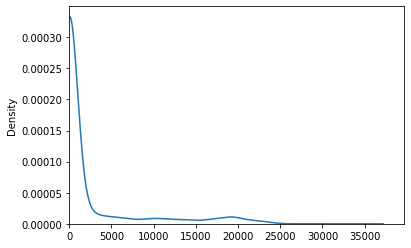

In [86]:
userRangeinHour = userRange.dt.total_seconds()/3600
userRangeinHour.plot(kind='kde')
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.show()

- 다음 그림은 Time을 minute으로 변환하여 그린 분포함수다.
  - 봉우리에 따라 분포를 쪼개면 session을 구할 수 있을 것이다.
  - 그러나 동적으로 session을 할당하기가 쉽지 않으므로 다른 대안을 고려한다 : 1시간 단위

<Figure size 720x1440 with 0 Axes>

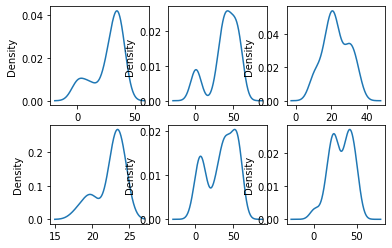

In [8]:
plt.figure(figsize = (10, 20))
fig, axes = plt.subplots(2,3)
count = 1
for ax in axes.flatten():
    data2['Time'][data2['UserId'] == count].dt.minute.plot(kind='kde', ax = ax)
    count += 1
plt.show()

- 1시간 단위로 나눈다

In [ ]:
# sessionId = 1
# sessions = pd.Series()
# for userid in data2['UserId'].unique():
#     origin = data2['Time'][data2['UserId'] == userid].iloc[0]
#     offset = data2['Time'][data2['UserId'] == userid] - origin
#     criteria = dt.timedelta(hours=1)
#     offset.map(lambda x : x > criteria)
#     sessions = pd.concat([sessions, offset + sessionId], axis = 0 )
#     sessionId = sessions.max() + 1
#     if userid > 10 : break

In [374]:
data2['Time_diff'] = data2['Time'].diff().fillna(pd.Timedelta(seconds=0))
data2['Change_User'] = data2['UserId'].diff().fillna(0)

sessionId = 1
def make_sessions(x):
    global sessionId
    if x['Time_diff'] > dt.timedelta(hours=1) or x['Change_User']==1:
        sessionId += 1
    return sessionId

In [375]:
data2['SessionId'] = data2.apply(make_sessions, axis=1)

In [376]:
data2 = data2.drop(columns = ['Time_diff', 'Change_User'])

In [377]:
data2

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,1
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,24412
1000205,6040,1921,4,2001-08-10 14:41:04,24412
1000206,6040,1784,3,2001-08-10 14:41:04,24412
1000207,6040,161,3,2001-08-10 14:41:26,24412


### 2.2 Session Length

In [126]:
session_length = data2.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
24409      7
24410     14
24411      1
24412     21
24413      1
Length: 24413, dtype: int64

(0.0, 0.022622876690066004)

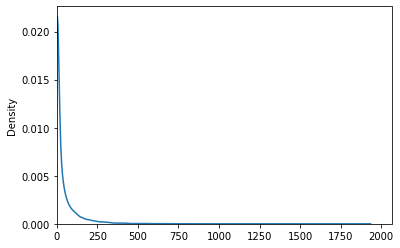

In [128]:
session_length.plot(kind='kde')
plt.xlim(left = 0)
plt.ylim(bottom = 0)

In [129]:
session_length.min(), session_length.max()

(1, 1290)

In [130]:
session_length.median(), session_length.mean()

(6.0, 40.97034366935649)

In [132]:
session_length.quantile(0.99)

400.0

In [164]:
long_session = session_length[session_length==200].index[0]
data2[data2['SessionId']==long_session]

,UserId,ItemId,Rating,Time,Time_diff,Change_User,SessionId
66933,451,946,5,2000-12-10 02:15:22,2 days 02:02:56,0.0,2052
66934,451,3872,4,2000-12-10 02:16:19,0 days 00:00:57,0.0,2052
66935,451,3808,4,2000-12-10 02:17:07,0 days 00:00:48,0.0,2052
66936,451,1204,5,2000-12-10 02:17:07,0 days 00:00:00,0.0,2052
66937,451,1252,5,2000-12-10 02:18:24,0 days 00:01:17,0.0,2052
...,...,...,...,...,...,...,...
67128,451,1641,5,2000-12-10 03:06:16,0 days 00:02:08,0.0,2052
67129,451,3260,4,2000-12-10 03:06:16,0 days 00:00:00,0.0,2052
67130,451,497,5,2000-12-10 03:06:16,0 days 00:00:00,0.0,2052
67131,451,3868,3,2000-12-10 03:06:16,0 days 00:00:00,0.0,2052


In [166]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_999

1      0.272601
2      0.372957
3      0.423176
4      0.455003
5      0.481874
         ...   
395    0.989637
396    0.989678
397    0.989719
398    0.989841
399    0.989923
Length: 389, dtype: float64

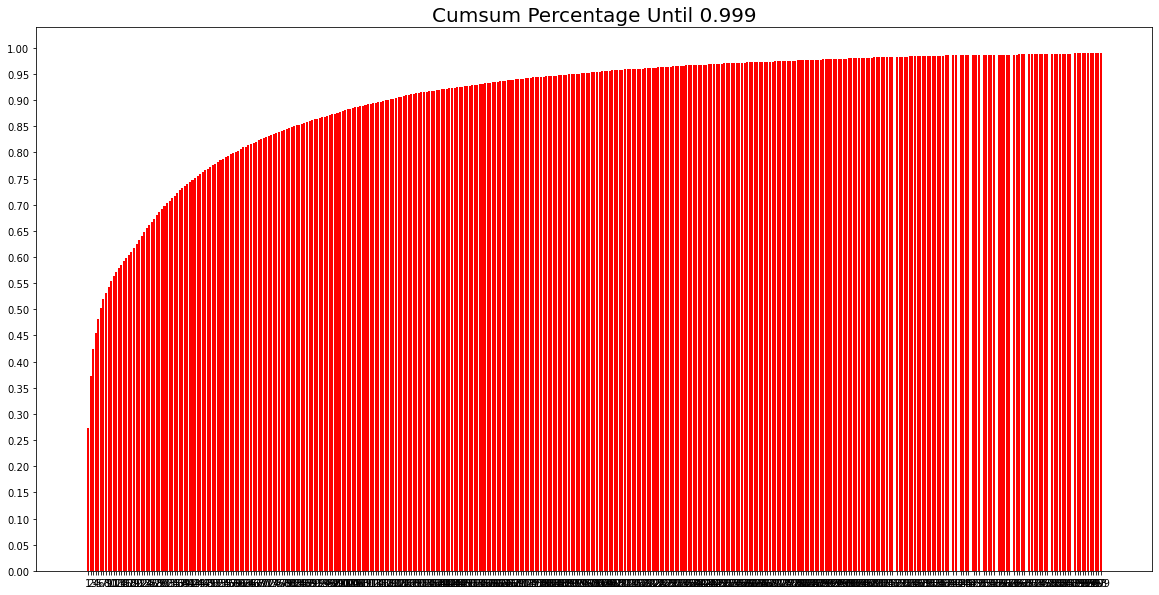

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 2.3 Session Time

In [168]:
oldest, latest = data2['Time'].min(), data2['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [169]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- 영화는 고전이 오히려 유행이므로 버리지 않아! -> 좋지 않은 결과. 최신의 영향을 배제하지 못함.
- 1년(365일)를 기준으로 삼는다.

In [378]:
year_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 120일 이전 날짜를 구한다.  
data2 = data2[data2['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data2

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,2002-03-12 03:46:59,83
5334,36,1201,4,2002-03-12 03:46:59,83
5335,36,1291,5,2002-03-12 03:47:16,83
5336,36,2167,5,2002-03-12 03:48:25,83
5337,36,2951,4,2002-03-12 03:48:25,83
...,...,...,...,...,...
992789,5996,3835,3,2002-04-29 20:46:24,24305
992790,5996,2422,3,2002-04-29 20:47:05,24305
992791,5996,168,3,2002-09-03 13:12:26,24306
992792,5996,339,4,2002-10-07 13:24:39,24307


2.4 Data Cleansing

In [206]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [381]:
data_base = cleanse_recursive(data2, shortest=2, least_click=5)
data_last = cleanse_recursive(data2, shortest=2, least_click=20)

In [382]:
data_last

,UserId,ItemId,Rating,Time,SessionId
5335,36,1291,5,2002-03-12 03:47:16,83
5338,36,2115,5,2002-03-12 03:48:25,83
5361,36,296,5,2002-12-22 08:16:59,86
5363,36,1266,5,2002-12-22 08:18:29,86
5364,36,595,4,2002-12-22 08:18:29,86
...,...,...,...,...,...
992737,5996,3039,4,2002-04-29 19:46:04,24305
992753,5996,3791,3,2002-04-29 19:58:39,24305
992765,5996,3247,4,2002-04-29 20:05:17,24305
992770,5996,3826,1,2002-04-29 20:10:17,24305


## 추가적 데이터 정제시도: data_last의 경우
- 이렇게 짧은 시간에 과도한 클릭을 했다는 것은 특정한 의도를 담고 있을 수 있으므로 삭제
  - ① 한 세션이 3시간 이상이다 ? 버린다.
  - ② 한 세션에서 시간당 클릭량이 60회 이상이다 ? 버린다.
  - ③ 평가점수가 2이하다? 보지 말라는 의미이므로 버린다.

In [383]:
#세션의 시간을 살펴보자
SessionRange = (data_last.groupby('SessionId')['Time'].max() - data_last.groupby('SessionId')['Time'].min())
drop1 = SessionRange[SessionRange > dt.timedelta(hours=3)].index
drop1

Int64Index([14290, 23156], dtype='int64', name='SessionId')

In [384]:
ItemClicking = data_last.groupby('SessionId')['SessionId'].count() / ( SessionRange.dt.total_seconds()/3600 )
drop2 = ItemClicking[ItemClicking > 60].index
drop2

Int64Index([   83,    86,   146,   235,   237,   240,   380,   463,   575,
             1043,
            ...
            23036, 23044, 23569, 23570, 23571, 23636, 23837, 23838, 23839,
            24167],
           dtype='int64', name='SessionId', length=216)

In [385]:
drop1 = list(drop1)
drop2 = list(drop2)
drop = set(drop1 + drop2)
len(drop)

218

In [386]:
data_last = data_last[(~data_last.SessionId.isin(drop))]

In [387]:
data_last[data_last.Rating>=3]

,UserId,ItemId,Rating,Time,SessionId
8789,59,2997,4,2003-01-07 18:02:48,123
8792,59,3408,4,2003-01-07 18:04:52,123
8794,59,2716,3,2003-01-07 18:05:31,123
8797,59,2396,4,2003-01-07 18:07:15,123
8800,59,2762,3,2003-01-07 18:07:15,123
...,...,...,...,...,...
992735,5996,10,4,2002-04-29 19:43:40,24305
992737,5996,3039,4,2002-04-29 19:46:04,24305
992753,5996,3791,3,2002-04-29 19:58:39,24305
992765,5996,3247,4,2002-04-29 20:05:17,24305


---

In [388]:
dataset = data_last.copy()

dataset.reset_index(drop=True, inplace=True)
dataset['Change_Session'] = dataset['SessionId'].diff().fillna(0)

newSessionId = 0
def reset_sessions(x):
    global newSessionId
    if x['Change_Session']:
        newSessionId += 1
    return newSessionId
         
dataset['SessionId'] = dataset.apply(reset_sessions, axis=1)
dataset = dataset[['ItemId', 'Time', 'SessionId']]
dataset

,ItemId,Time,SessionId
0,2997,2003-01-07 18:02:48,0
1,3408,2003-01-07 18:04:52,0
2,2716,2003-01-07 18:05:31,0
3,2396,2003-01-07 18:07:15,0
4,2762,2003-01-07 18:07:15,0
...,...,...,...
2831,3039,2002-04-29 19:46:04,355
2832,3791,2002-04-29 19:58:39,355
2833,3247,2002-04-29 20:05:17,355
2834,3826,2002-04-29 20:10:17,355


### 2.5 Train/ Valid/ Test split

In [293]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [415]:
tr, test = split_by_date(dataset, n_days=10)
tr, val = split_by_date(tr, n_days=30)

In [407]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [408]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 2626
	 Sessions: 330
	 Items: 155
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2003-01-14 20:28:50

* valid Set Stats Info
	 Events: 132
	 Sessions: 17
	 Items: 85
	 First Time : 2003-01-15 05:14:13
	 Last Time : 2003-02-14 02:02:32

* test Set Stats Info
	 Events: 78
	 Sessions: 9
	 Items: 61
	 First Time : 2003-02-19 15:43:49
	 Last Time : 2003-02-27 18:15:10



In [416]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [298]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [255]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [256]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,ItemId,Time,SessionId,item_idx
0,934,2000-12-30 23:22:48,0,0
1,1641,2000-12-30 23:22:48,0,1
2,999,2000-12-30 23:22:48,0,2
3,2616,2000-12-30 23:22:48,0,3
4,3785,2000-12-30 23:22:48,0,4
5,3265,2000-12-30 23:28:36,0,5
6,1303,2000-12-30 23:28:36,0,6
7,1198,2000-12-30 23:29:09,0,7
8,813,2000-12-30 23:29:09,0,8
9,3897,2000-12-30 23:29:09,0,9


In [257]:
tr_dataset.click_offsets

array([    0,    23,    38, ..., 53913, 53918, 53925], dtype=int32)

In [258]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3725, 3726, 3727])

In [259]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [261]:
iter_ex = iter(tr_data_loader)

In [262]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 23 38 40]
Label Item Idx are :       [ 1 24 39 41]
Previous Masked Input Idx are []


### Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [263]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [264]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [420]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [421]:
model = create_model(args)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(16, 1, 155)]            0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      31050     
_________________________________________________________________
dropout_16 (Dropout)         (16, 50)                  0         
_________________________________________________________________
dense_16 (Dense)             (16, 155)                 7905      
Total params: 38,955
Trainable params: 38,955
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [269]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [270]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [422]:
train_model(model, args)

Train:   0%|          | 0/143 [00:00<?, ?it/s, accuracy=0, train_loss=5.03]     

	 - Recall@20 epoch 1: 0.187500
	 - MRR@20    epoch 1: 0.021519



Train:   0%|          | 0/143 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@20 epoch 2: 0.312500
	 - MRR@20    epoch 2: 0.048390



Train:   0%|          | 0/143 [00:00<?, ?it/s, accuracy=0, train_loss=4.97]     

	 - Recall@20 epoch 3: 0.312500
	 - MRR@20    epoch 3: 0.079241



Train:   0%|          | 0/143 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.9] 

	 - Recall@20 epoch 4: 0.375000
	 - MRR@20    epoch 4: 0.061384



Evaluation:  14%|█▍        | 1/7 [00:00<00:00,  9.70it/s]

	 - Recall@20 epoch 5: 0.500000
	 - MRR@20    epoch 5: 0.054110



### Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [325]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  54%|█████▍    | 49/91 [00:09<00:08,  5.03it/s]

	 - Recall@20: 0.181122
	 - MRR@20: 0.064290



### 베이스 모델의 경우
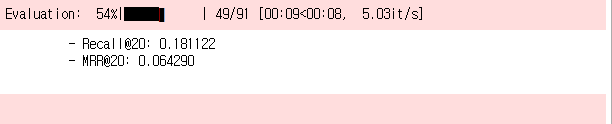

### 모든 데이터 활용, least_click=20, 추가정제의 경우
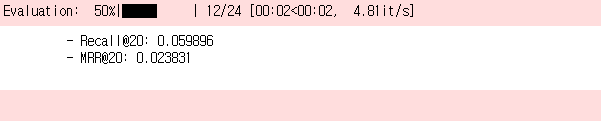

### 최근 1년의 데이터로 추정한 경우, least_click = 20, 추가 정제의 경우
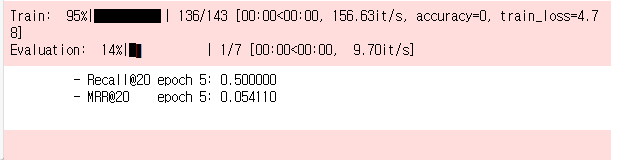

# 결론 및 회고
- Recall@20 : 0.5, MRR@20: 0.05의 값이 나왔다.
- 해당 노드를 진행하면서 datetime, timedelta에 대한 이해를 높일 수 있었다. 코딩도장에 있는 내용이 큰 도움이 되었다.
- 전처리 부분에서 시도할 수 있는 내용들이 몇 가지 있어 가능한 많은 방법을 시도했다.
- 그러나 모델 부분의 코드는 이해하기에 어려움이 있었고, 개별적인 공부가 필요해 보인다.
- 여러가지 하이퍼파라미터를 조정하면서 접근하였으나, 명확한 기준이 없이 찍듯이 접근했다. 상식적인 사고를 통해 파라미터를 조정했으나 결과가 좋아지는 걸 보니 신기했다. 추천시스템을 핵심역량으로 삼아도 될까? 많은 고민이 되는 노드다.